# Deep Convolutional Generative Adversarial Network (DCGAN) Tutorial



Adapted from Arthur Juliani, see his post here [Medium post](https://medium.com/p/54deab2fce39) on his implementation of DCGAN.

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

/Users/jonathansherman/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically.

In [2]:
from PIL import Image
import tarfile

# Download dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
import os
import urllib
from urllib.request import urlretrieve
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend(result['data'].reshape(-1,32,32,3)/255*2-1)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data'].reshape(-1,32,32,3)/255*2-1)
        test_y=np.int32(result['labels'])


load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


In [3]:
test_X.shape

(10000, 32, 32, 3)

In [4]:
train_X = np.concatenate([train_X, test_X])
train_X = np.concatenate([train_X[:,:,:,::-1], train_X])
train_X.shape

(120000, 32, 32, 3)

### Helper Functions

In [5]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
#def save_images(images, size, image_path):
#    return imsave(inverse_transform(images), size, image_path)

#def imsave(images, size, path):
#    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided  transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [6]:
def generator(z):
    
    zP = slim.fully_connected(z,4*4*256*3,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256*3])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=3,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network
The discriminator network takes as input a 32x32 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [7]:
def discriminator(bottom, reuse=False):
    
    dis1 = slim.convolution2d(bottom,16,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    
    dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    
    dis3 = slim.convolution2d(dis2,64,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    
    d_out = slim.fully_connected(slim.flatten(dis3),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d_out', weights_initializer=initializer)
    
    return d_out

### Connecting them together

In [8]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.
z_channels = 3

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,3],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
print(Gz.shape)
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

(?, 32, 32, 3)


## Training the network
Now that we have fully defined our network, it is time to train it!

(128, 100)
Gen Loss: 0.8076596 Disc Loss: 1.5076385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


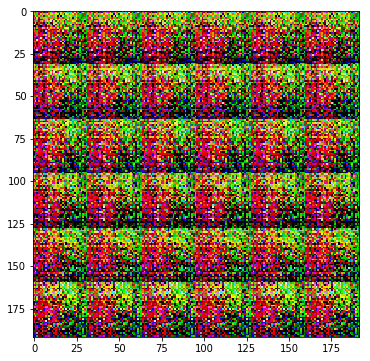

(128, 100)
Gen Loss: 0.48776564 Disc Loss: 1.9249343


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


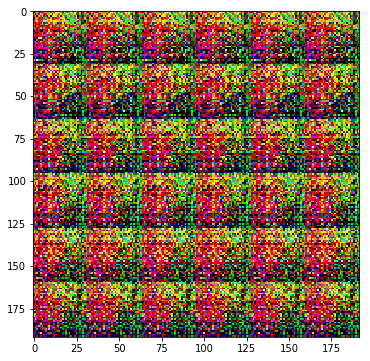

(128, 100)
Gen Loss: 0.35446614 Disc Loss: 2.2109296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


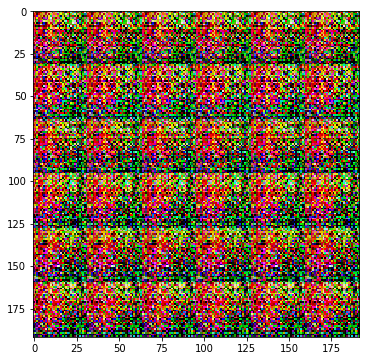

(128, 100)
Gen Loss: 0.26906136 Disc Loss: 2.4742076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


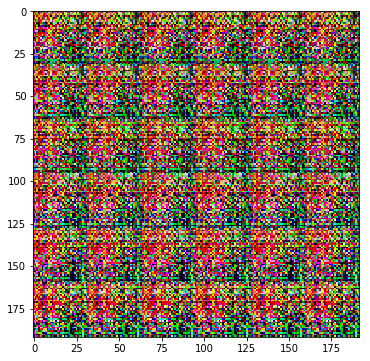

(128, 100)
Gen Loss: 0.23886117 Disc Loss: 2.6099792


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


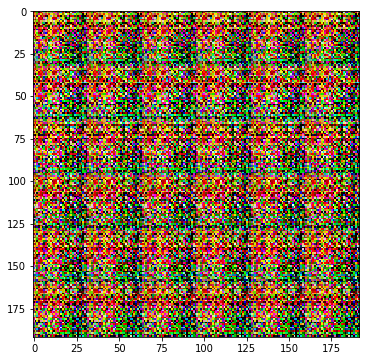

(128, 100)
Gen Loss: 0.235176 Disc Loss: 2.6531525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


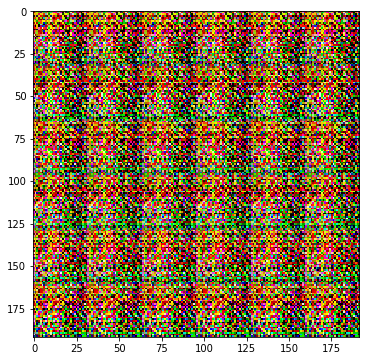

(128, 100)
Gen Loss: 0.25424063 Disc Loss: 2.599125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


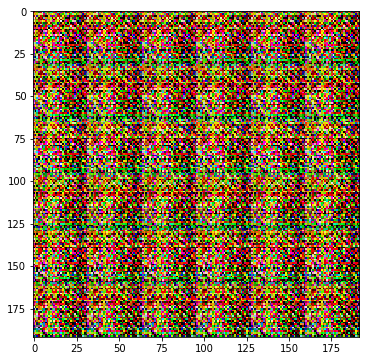

(128, 100)
Gen Loss: 0.27451992 Disc Loss: 2.5418763


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


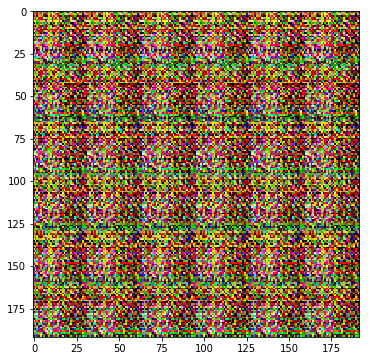

(128, 100)
Gen Loss: 0.28255987 Disc Loss: 2.5221343


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


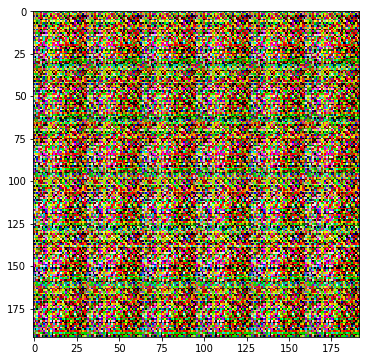

(128, 100)
Gen Loss: 0.29684263 Disc Loss: 2.4752297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


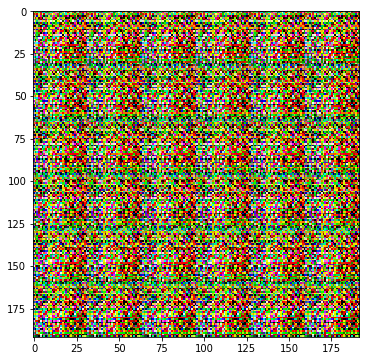

(128, 100)
Gen Loss: 0.296839 Disc Loss: 2.4885082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


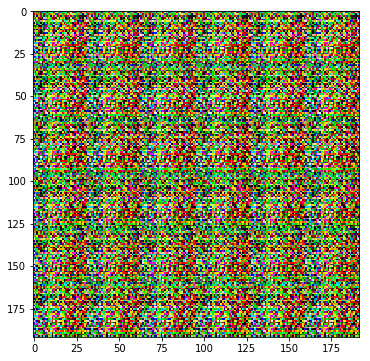

(128, 100)
Gen Loss: 0.2808677 Disc Loss: 2.5538168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


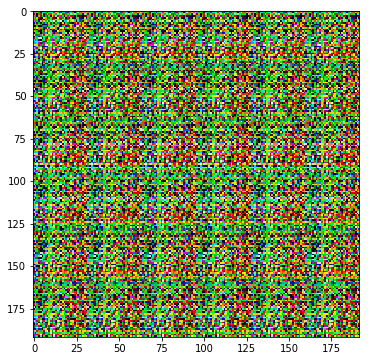

(128, 100)
Gen Loss: 0.28125 Disc Loss: 2.5762327


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


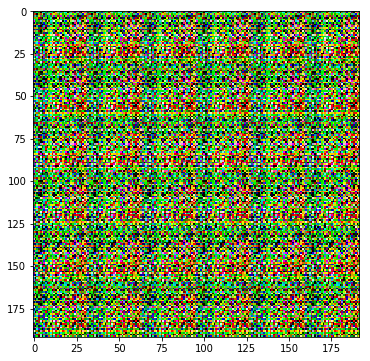

(128, 100)
Gen Loss: 0.28542668 Disc Loss: 2.5831065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


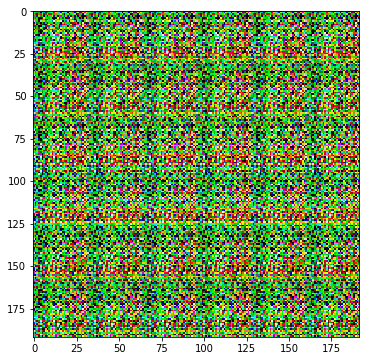

(128, 100)
Gen Loss: 0.2688437 Disc Loss: 2.6519423


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


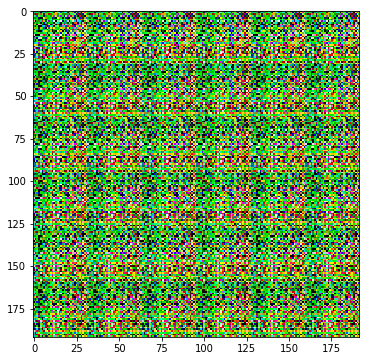

(128, 100)
Gen Loss: 0.26682848 Disc Loss: 2.6716213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


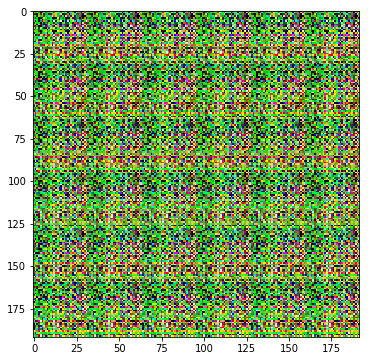

(128, 100)


KeyboardInterrupt: 

In [42]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500 #Total number of iterations to use.
#sample_directory = './figs' #Directory to save sample images from generator in.
#model_directory = './models' #Directory to save trained model to.

np.random.shuffle(train_X)
init = tf.global_variables_initializer()
#saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        np.random.shuffle(train_X)
        batches = train_X.shape[0]//batch_size
        while i < batches:
            zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
            print(zs.shape)
            xs = train_X[i*batch_size:(i+1)*batch_size]
            xs = (np.reshape(xs,[batch_size,32,32,3]) - 0.5) * 2.0 #Transform it to be between -1 and 1
            #xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
            _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
            _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
            #_,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
            if i % 10 == 0:
                print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
                n = 6
                canvas = np.empty((32 * n, 32 * n, 3))
                for j in range(n):
                    # Noise input.
                    z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
                    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
                    # Reverse colours for better display
                    newZ = -1 * (newZ)
                    for k in range(n):
                        # Draw the generated digits
                        canvas[j * 32:(j + 1) * 32, k * 32:(k + 1) * 32, 0:3] = newZ[j].reshape([32, 32, 3])


                plt.figure(figsize=(n, n))
                ax = plt.gca()
                ax.grid(False)
                plt.imshow(canvas, origin="upper", cmap=None)
                plt.show()


                #if not os.path.exists(sample_directory):
                #    os.makedirs(sample_directory)
                #Save sample generator images for viewing training progress.
                #save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
            #if i % 1000 == 0 and i != 0:
                #if not os.path.exists(model_directory):
                #    os.makedirs(model_directory)
                #saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
                #print("Saved Model")

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [ ]:
"""
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
"""